In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import stats
import tqdm
import seaborn as sns


source_all = pd.read_csv('../../data/source_all.csv')
thre = 0.1  # {0.1,0.2}
poli_range = [-2,-thre, thre-0.00000001,2]
suffix = str(thre)
i2poli = source_all[source_all['manual']<90]
i2poli = i2poli[['i','manual']]
i2poli.rename(columns={'manual':'poli'},inplace=True)

i2poli, source_all = i2poli.set_index('i'), source_all.set_index('i')
with open('../get_effect/result/mind/policy_effect_o2j.pkl', 'rb') as file:
    peo2j = pickle.load(file)
news = pd.read_csv('../../data/all_news.csv').set_index('i')

In [2]:
nv, nj = 2, 3
index = ['notpoli','poli']
df1 = pd.DataFrame(np.empty(nv*nj).reshape(nv,nj), columns=['{}'.format(i+1) for i in range(nj)], index=index)
df2 = pd.DataFrame(np.empty(nv*nj).reshape(nv,nj), columns=['{}'.format(i+1) for i in range(nj)], index=index)
mid_list, left_list, right_list = [], [], []

for a in tqdm.tqdm(index):
    for b in tqdm.tqdm(list(range(nj))):
        v_effect, count = [], 0
        for j in peo2j:
            if j not in i2poli.index or i2poli.loc[j,'poli'] <= poli_range[b] or i2poli.loc[j,'poli'] > poli_range[b+1] or source_all.loc[j,'click']<1:
                continue
            for v in peo2j[j]:
                if v not in news.index or news.loc[v,'p']!= a:
                    continue
                v_effect.append(peo2j[j][v])
                count += 1
        if len(v_effect) == 0:
            ave_effect = 0
        else:
            ave_effect = np.mean(v_effect)
        if b==0:
            left_list.extend(v_effect)
        elif b==2:
            right_list.extend(v_effect)
        else:
            mid_list.extend(v_effect)
        df1.loc[a,'{}'.format(b+1)] = ave_effect
        df2.loc[a,'{}'.format(b+1)] = count

h_all = (df1*df2).sum(axis=1) / df2.sum(axis=1)
v_all = (df1*df2).sum(axis=0) / df2.sum(axis=0)
all_effect = sum((df1*df2).values.reshape(-1)) / sum((df2).values.reshape(-1))
df1['all'] = h_all
df1.loc['all'] = v_all
df1.loc['all','all'] = all_effect
df1.columns = ['Left','Center','Right','All']
# df1.index = ['Non-political','Political','All']
df1.index = ['Non-poli.','Poli.','All']

100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


***** Wilcoxon-Mann-Whitney test *****
pval_left_right 1.0584072026737945e-14
pval_left_mid 0.9999183928681178
pval_mid_right 9.711780488117707e-20
0.0021045407275087024 0.0028477625735970676 0.00047502232612604064


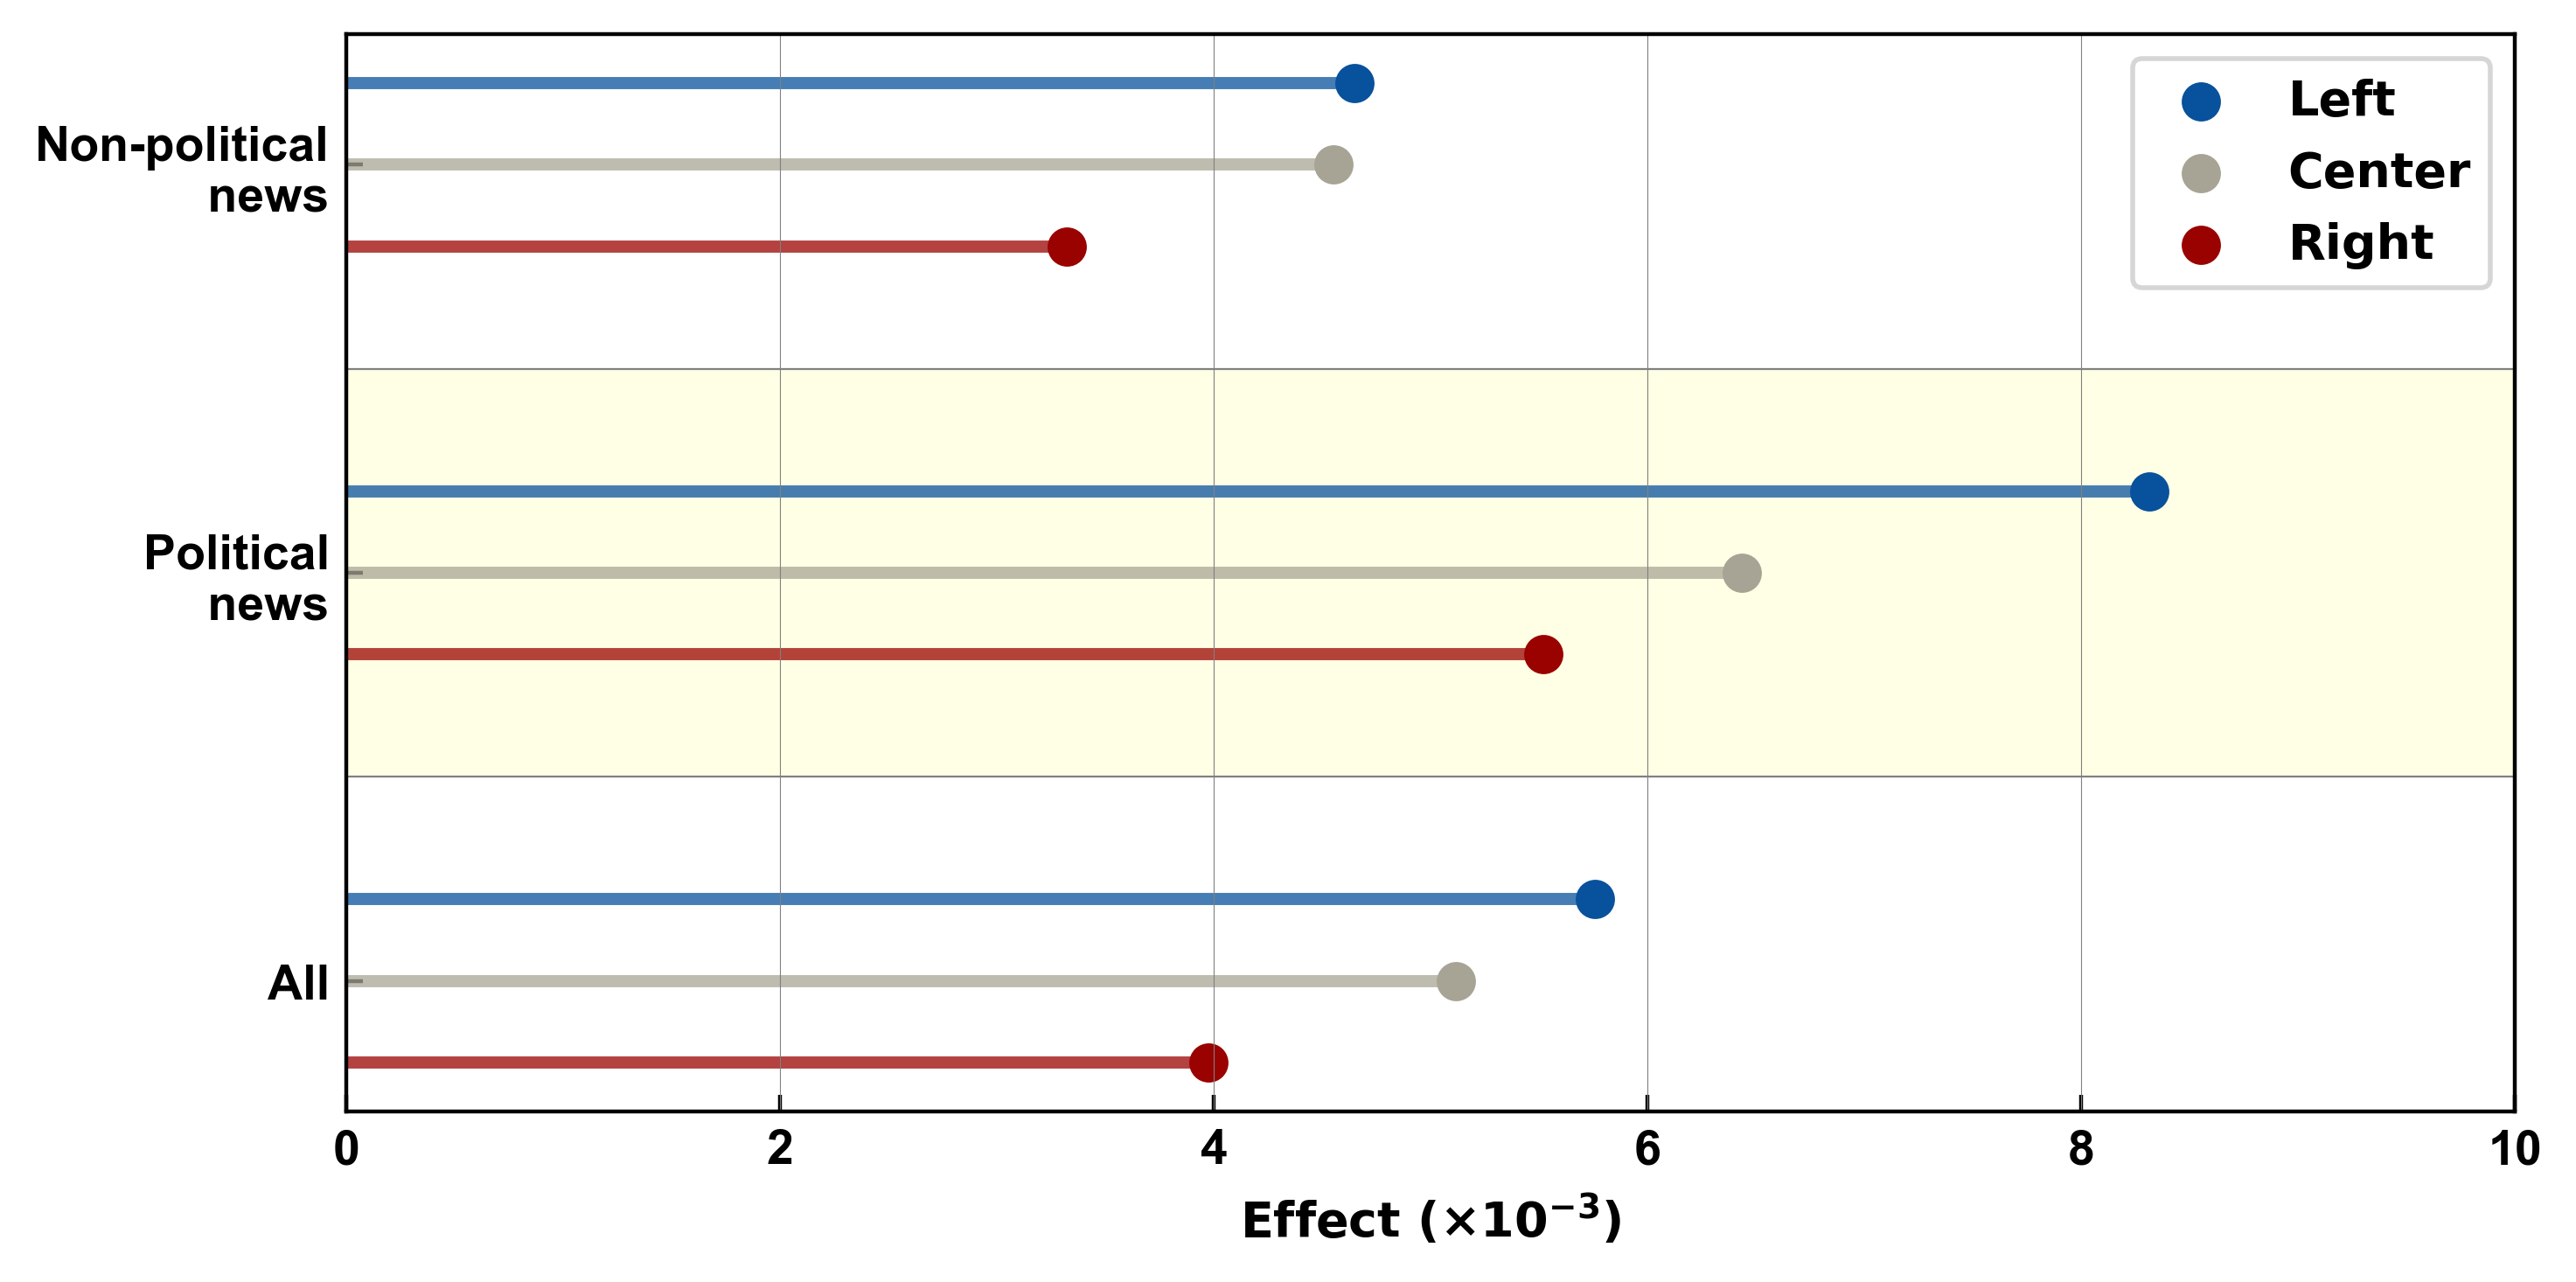

In [3]:
print('***** Wilcoxon-Mann-Whitney test *****')
pval_left_right = tuple(stats.mannwhitneyu(left_list, right_list, alternative='greater'))[1]
print('pval_left_right',pval_left_right)
pval_left_mid = tuple(stats.mannwhitneyu(left_list, mid_list, alternative='greater'))[1]
print('pval_left_mid',pval_left_mid)
pval_mid_right = tuple(stats.mannwhitneyu(mid_list, right_list, alternative='greater'))[1]
print('pval_mid_right',pval_mid_right)
print(np.median(left_list),np.median(mid_list),np.median(right_list))

df1_arr = np.array(df1.values)
fig, ax = plt.subplots(figsize=(8,4),dpi=400)
ax.axhspan(1.5,2.5,facecolor='yellow',alpha=0.1)

k = 3
left_effect_arr = df1_arr[::-1,0]
ax.hlines(y=[i+1.2 for i in range(k)], xmin=0, xmax=left_effect_arr, color='#08519c', alpha=0.75, ls='-', lw=2.5)
ax.scatter(left_effect_arr, [i+1.2 for i in range(k)], color='#08519c', s=50, alpha=1, label='Left')

mid_effect_arr = df1_arr[::-1,1]
ax.hlines(y=[i+1 for i in range(k)], xmin=0, xmax=mid_effect_arr, color='#a8a495', alpha=0.75, ls='-', lw=2.5)
ax.scatter(mid_effect_arr, [i+1 for i in range(k)], color='#a8a495', s=50, alpha=1, label='Center')

right_effect_arr = df1_arr[::-1,2]
ax.hlines(y=[i+0.8 for i in range(k)], xmin=0, xmax=right_effect_arr, color='#9a0200', alpha=0.75, ls='-', lw=2.5)
ax.scatter(right_effect_arr, [i+0.8 for i in range(k)], color='#9a0200', s=50, alpha=1, label='Right')
ax.legend(loc='upper right', prop={'weight': 'bold'})

if poli_range[1] == -0.2:
    ax.set_xlim((0,0.01))
    ax.set_xticks([0,0.002,0.004,0.006,0.008,0.01],labels=['0','2','4','6','8','10'])
    ax.hlines(y=1.5, xmin=0, xmax=0.01, color='grey', ls='-', lw=0.4)
    ax.hlines(y=2.5, xmin=0, xmax=0.01, color='grey', ls='-', lw=0.4)
    for x in [0.002,0.004,0.006,0.008]:
        plt.axvline(x=x, c="grey", ls="-", lw=0.2)
else:
    ax.set_xlim((0,0.01))
    ax.set_xticks([0,0.002,0.004,0.006,0.008,0.01],labels=['0','2','4','6','8','10'])
    ax.hlines(y=1.5, xmin=0, xmax=0.01, color='grey', ls='-', lw=0.4)
    ax.hlines(y=2.5, xmin=0, xmax=0.01, color='grey', ls='-', lw=0.4)
    for x in [0.002,0.004,0.006,0.008]:
        plt.axvline(x=x, c="grey", ls="-", lw=0.2)

ax.set_yticks([i+1 for i in range(k)], ['All']+['Political\n news','Non-political\n news'])
ax.set_xlabel(r'Effect $\mathbf{(\times 10^{-3})}$', weight='bold')
plt.yticks(fontproperties='Arial', size=10, weight='bold')
plt.xticks(fontproperties='Arial', size=10, weight='bold')
plt.tick_params(direction='in')

if poli_range[1] == -0.2:
    plt.savefig('./figures/poli_nonpoli_vs_lcr_{}_S5C.pdf'.format(suffix), dpi=400,bbox_inches='tight',pad_inches=0)
else:
    plt.savefig('./figures/poli_nonpoli_vs_lcr_{}_2C.pdf'.format(suffix), dpi=400,bbox_inches='tight',pad_inches=0)
plt.show()